### Importing

In [43]:
# pip install -r ../python_requirements.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
import time
import io

from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

In [3]:
np.seterr(all='raise')

{'divide': 'raise', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [4]:
read_file = pd.read_csv('kdd_log_df.csv')
kdd_log_df = pd.DataFrame(read_file)

read_file = pd.read_csv('kdd_df.csv')
kdd_df = pd.DataFrame(read_file)

In [5]:
kdd_log_df.head()

,duration,src_bytes,dst_bytes,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,connection_type,connection_category
0,0.0,5.204007,8.603554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
1,0.0,5.480639,6.188264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
2,0.0,5.463832,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
3,0.0,5.393628,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal
4,0.0,5.384495,7.617268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,normal,normal


Our project will focus on examining new connections to identify whether the connection in question is normal or an attack. One approach that could be taken is to train a series of predictive models on our existing dataset and pick the best performing one (based on some performance metric such as Cohen's Kappa) to be our final model that identifies any potential attacks. The problem with this, however, is that there may be new types of unseen attacks that do not appear in our dataset and thus we would not know if our model was only capable of identifying new attacks or if it could identify unseen attacks, which would be a major flaw. 

Instead, our approach is as follows:
- Remove a certain type of attack from our dataset (this is our artificial 'unseen' attack type).
- Train the model on the remainder of the attacks.
- Measure how well the model can predict whether a connection is an attack or not based on attacks that it has alread seen. (We use Cohen's Kappa to measure this performance).
- Measure how well the model can identify that the 'unseen' attacks are indeed attacks. (We use accuracy to measure this performance).
- Take an average of our two metrics to identify how well our model can predict that a new connection is an attack given that it has not seen some attack type(s).
- Repeat this for all other attacks.

Our model is not interested in what type a certain attack belongs to and therefore we create a copy dataframe that re-labels all attack types to simply 'attack'. The reason we create a copy is so that the original is available for us to filter out attacks later.

In [6]:
cols = kdd_log_df.columns

features = kdd_log_df[cols[:-2]].copy()
target = kdd_log_df[cols[-1]].copy()
target = target.apply(lambda x: x if 'normal' in x else 'attack')

In [7]:
features.head()

,duration,src_bytes,dst_bytes,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_access_files,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,5.204007,8.603554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,5.480639,6.188264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,5.463832,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,5.393628,7.198931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,5.384495,7.617268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [8]:
target.head()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: connection_category, dtype: object

We look at a pseudo-random split of the data for now just to assess performance, we will explore different ways of splitting the data later for the purpose of our test.

In this first iteration, we decided to try a Random Forest model.

In [9]:
X = features.copy()
y = target.copy()

kf = KFold(n_splits=2)

start = time.time()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
    rdF.fit(X_train,y_train)
    
    pred = rdF.predict(X_test)
    cm = confusion_matrix(y_test, pred)

    print('Model:',rdF)
    print()
    
    print('Cohen Kappa Score:',cohen_kappa_score(y_test, pred))
    print()
    
    print('Confusion Matrix:')
    print(cm)
    print()
    
    print('---')

end = time.time()

print()
print('Time elapsed:',end-start,'seconds')

Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen Kappa Score: 0.9835516590450124

Confusion Matrix:
[[174117   1669]
 [    10  71215]]

---
Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen Kappa Score: 0.9980075955286686

Confusion Matrix:
[[220868     89]
 [     4  26049]]

---

Time elapsed: 31.111045598983765 seconds


It may not be immediately obvious from the Cohen's Kappa score but the confusion matrix suggests that our model performed better when training on the second fold by a seemingly significant amount.

*N.B.: We were initially unsure why this was the case and build our model in this manner before realising that this was maybe related to the way that the `KFold()` function works: that is when `Shuffle` is not set to True, the split is not random and that some sub-section of the data contain a sequence of consecutive observations that correspond to attacks that are more difficult to identify. We will revisit this point later but for now you can see that the `KFold()` function below is simply cutting the data into the first and second half of all observations.

*More on this can be seen in the 04 - Python Appendix*

In [10]:
for train_index, test_index in kf.split(X):
    print('TRAIN:',train_index,'TEST:',test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [247011 247012 247013 ... 494018 494019 494020] TEST: [     0      1      2 ... 247008 247009 247010]
TRAIN: [     0      1      2 ... 247008 247009 247010] TEST: [247011 247012 247013 ... 494018 494019 494020]


We now consider dimensionality reduction in the form of PCA for two reasons:
1. Reducing dimensions could help reduce the runtime on our algorithm which would be helpful as we will be iterating over every single attack type
2. We may be able to create informative visualisations in lower dimensions (namely 2-d or 3-d)

In [12]:
X = features.copy()
y = target.copy()

X_scale = scale(X.T).T

In [13]:
for k in range(10):
    #we do not want k==0
    k += 1
    pca = PCA(n_components=k)
    pca.fit(X_scale)
    
    print('Dimensions:',k, 'Total variance accounted: %.3f' % sum(pca.explained_variance_ratio_))

Dimensions: 1 Total variance accounted: 0.494
Dimensions: 2 Total variance accounted: 0.835
Dimensions: 3 Total variance accounted: 0.886
Dimensions: 4 Total variance accounted: 0.929
Dimensions: 5 Total variance accounted: 0.951
Dimensions: 6 Total variance accounted: 0.967
Dimensions: 7 Total variance accounted: 0.979
Dimensions: 8 Total variance accounted: 0.984
Dimensions: 9 Total variance accounted: 0.987
Dimensions: 10 Total variance accounted: 0.990


We decide to keep the first 5 principal components as that is the lowest number of components that retains at least 95% of the variance for our dataset. So we run PCA with k=5:

In [14]:
pca = PCA(n_components = 5)
pc5_scale = pca.fit_transform(X_scale)
print(pca.explained_variance_ratio_)

[0.49390477 0.34146837 0.05082199 0.04241277 0.02205581]


In [15]:
pc_df_scale = pd.DataFrame(data = pc5_scale, columns = ['PC'+str(i+1) for i in range(5)])
pc_df_scale['Cluster'] = y
pc_df_scale.head()

,PC1,PC2,PC3,PC4,PC5,Cluster
0,6.325551,4.715814,-1.133008,-3.151920,1.000002,normal
1,5.752937,3.316056,-0.890335,-2.042397,0.072884,normal
2,5.781730,3.958605,-0.678531,-2.084608,0.148626,normal
3,5.815216,4.195085,-0.531643,-1.710144,-0.029644,normal
4,5.788756,4.425027,-0.432552,-1.694509,-0.009096,normal


<AxesSubplot:xlabel='PC', ylabel='var'>

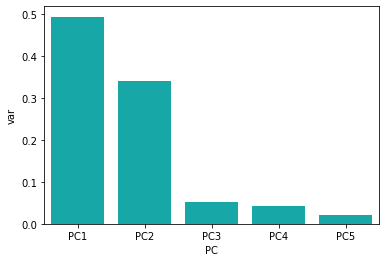

In [16]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,'PC':['PC'+str(i+1) for i in range(5)]})
sns.barplot(x='PC',y="var", data=df, color="c")

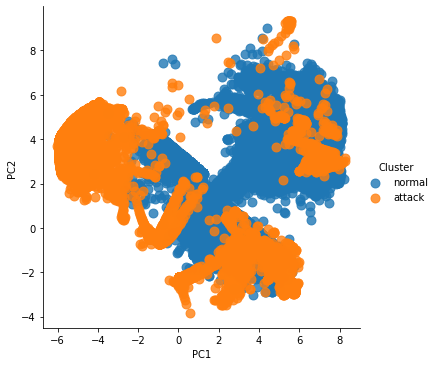

In [17]:
sns.lmplot( x="PC1", y="PC2",
  data=pc_df_scale, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

Despite the first 2 principal components retaining 83% of the variance we can see from the plot below that there isn't a clear separation between normal connections and attacks:

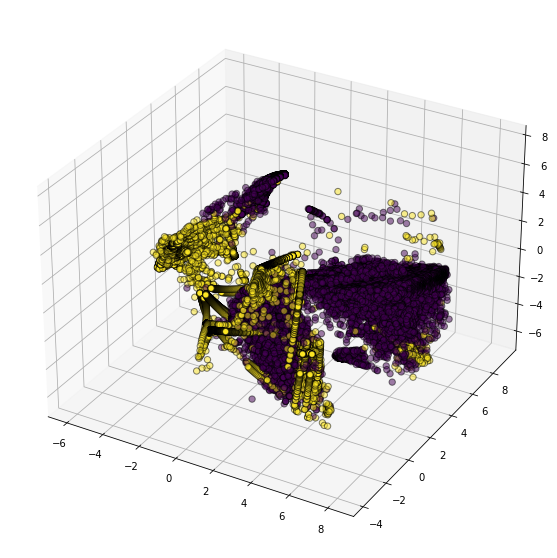

In [18]:
y_num = y.apply(lambda x: 0 if x=='normal' else 1)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=pc5_scale[:,0],ys=pc5_scale[:,1],zs=pc5_scale[:,2],
            c=y_num, cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)

The same could be said about the case with 3 dimensions/principal components as seen below. Some separation can be made between the two types of connections but it can still be difficult to interpret. This gives us some indication that PCA might be unhelpful for our dataset as the decision trees within the random forest may need greater depth to effectively highlight the separation between data clusters. 

We try this below to make sure:

In [19]:
# measure performance and speed using PCA


X = features.copy()
y = target.copy()

start = time.time()

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pca = PCA(n_components=5)
    X_train_scale = scale(X_train.T).T
    X5 = pca.fit_transform(X_train_scale)
    
    X_train_pca = pd.DataFrame(data=X5, columns = ['PC'+str(i+1) for i in range(5)])
    
    
    rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
    rdF.fit(X_train_pca,y_train)
    
    X_test_scale = scale(X_test.T).T
    X_t5 = pca.fit_transform(X_test_scale)
    X_test_pca = pd.DataFrame(data=X_t5, columns = ['PC'+str(i+1) for i in range(5)])
    
    pred = rdF.predict(X_test_pca)
    cm = confusion_matrix(y_test, pred)

    print('Model:',rdF)
    print()
    
    print('Cohen Kappa Score:',cohen_kappa_score(y_test, pred))
    print()
    
    print('Confusion Matrix:')
    print(cm)
    print()
    
    print('---')


end = time.time()

print()
print('Time elapsed:',end-start)

Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen Kappa Score: 0.6588910629900997

Confusion Matrix:
[[158666  17120]
 [ 17417  53808]]

---
Model: RandomForestClassifier(max_depth=50, random_state=45)

Cohen Kappa Score: -0.06240524166887873

Confusion Matrix:
[[ 66516 154441]
 [ 13352  12701]]

---

Time elapsed: 79.81647729873657


From what can be seen, not only did our model take longer to run with PCA, it also caused a significant decrease in performance. Surprisingly, however, we do observe a negative Cohen's Kappa score for the second split of the data which suggests that our model with PCA performed worse than predicting at random.

For this reason, we continue testing our model without any dimensionality reduction from this point forward.

In [32]:
#create list of attacks to iterate over later
attacks = [attack for attack in kdd_df.connection_type.value_counts().index]

As mentioned above, I initially overlooked the Shuffle arg in the `KFold()` function and ran the model below for 2 splits (to vaguely see if any information was missed from the data due to randomness). 

As a result, our first iteration of the model uses the above mistake and experiences highly varied performance based on the split that it is being trained on. This is seen below:

## Shuffling the Data


*N.B.: Due to an error that suddenly arose from scikitlearn indexing not working with pandas, the code below stopped working as intended.*

*The code was fixed but somehow the results changed drastically. Instead, we leave the code commented out and run it separately 
in the Appendix section for this part of the report.*

In [33]:
# X = features.copy()
# y = target.copy()

# attacks = [attack for attack in kdd_df.connection_type.value_counts().index]
# start = time.time()

# kf = KFold(n_splits = 2)

# for attack in attacks:
#     if attack=='normal':
#         pass
#     else:
#         non_atk = kdd_df.connection_type!=attack 
#         atk = kdd_df.connection_type==attack

#         print('--------','Performance on removing',attack,'attacks','--------')
#         X_non_atk = features[non_atk].copy()
#         X_atk = features[atk].copy()
#         y_non_atk = target[non_atk].copy()
#         y_atk = target[atk].copy()
        
#         for train_index, test_index in kf.split(X_non_atk):
#             X_train, X_test = X_non_atk.iloc[train_index], X_non_atk.iloc[test_index]
#             #an error occured here in the last minute of working on this project
#             #pandas was no longer accepting the old indexing of y_non_atk[train_index]
#             #having changed the format to y_non_atk.iloc[train_index], the whole set of results also changed
#             y_train, y_test = y_non_atk.iloc[train_index], y_non_atk.iloc[test_index]

#             rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
#             rdF.fit(X_train,y_train)

#             pred = rdF.predict(X_test)
#             cm = confusion_matrix(y_test, pred)

#             pred_new = rdF.predict(X_atk)
#             accuracy_new = accuracy_score(y_atk,pred_new)
#             cm_new =confusion_matrix(y_atk, pred_new)


#             print('Model:',rdF)
#             print()
#             print('Accuracy (unknown',attack,'attacks:',accuracy_new)
#             print()

#             print('Classification report (known attacks):')
#             print((classification_report(y_test,pred, labels=None)))
#             print()

#             print('Cohen Kappa Score (known attacks):',cohen_kappa_score(y_test, pred))
#             print()

#             print('Confusion Matrix (known attacks):')
#             print(cm)
#             print()
#             print('Confusion Matrix (unknown',attack,'attacks):')
#             print(cm_new)    
#             print()



#             print('---')


# end = time.time()

# print()
# print('Time elapsed:',end-start,'seconds')

*Luckily, I had made a back-up of the results and saved it as a .txt file. However, due to this, the code cannot be editted to clean up and make the results as readable as I would have hoped. The results are shown and will be commented on below:*

## Shuffling the Data

In [44]:
with open('../text_data/original_string.txt', 'r') as file:
    orig_str = file.read()
    
print(orig_str)

a = '''-------- Performance on removing smurf attacks --------
Model: RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)

Accuracy (known attacks): 0.9837641629774143
Accuracy (unknown smurf attacks: 1.0

Classification report (known attacks):
              precision    recall  f1-score   support

  non-normal       1.00      0.96      0.98     47413
      normal       0.97      1.00      0.99     59203

    accuracy                           0.98    106616
   macro avg       0.99      0.98      0.98    106616
weighted avg       0.98      0.98      0.98    106616


Cohen Kappa Score (known attacks): 0.9670091611682816

Confusion Matrix (known attacks):
[[45702  1711]
 [   20 59183]]

Confusion Matrix (unknown smurf attacks):
[[280790]]

---
Model: RandomForestClassifier(max_depth=50, n_estimators=250, random_state=45)

Accuracy (known attacks): 0.9893073207334803
Accuracy (unknown smurf attacks: 0.999996438619609

Classification report (known attacks):
            

In [34]:
kdd_log_df.connection_type.value_counts()

smurf              280790
neptune            107201
normal              97278
back                 2203
satan                1589
ipsweep              1247
portsweep            1040
warezclient          1020
teardrop              979
pod                   264
nmap                  231
guess_passwd           53
buffer_overflow        30
land                   21
warezmaster            20
imap                   12
rootkit                10
loadmodule              9
ftp_write               8
multihop                7
phf                     4
perl                    3
spy                     2
Name: connection_type, dtype: int64

### Results' Interpretability
To briefly explain how the data above is to be read/interpreted, a single attack type is removed from the dataset on each iteration, then introduced on the next while another is removed. For instance, we initially remove smurf attacks and test the performance of the dataset on seen attacks, then on the 'unseen' smurf attacks. We initially explored a lot of different measures with the intention of keeping only the relevant ones once we made a final decision, which is why a lot of them are crammed in. However, as mentioned above, this cleaning was not done due to an error that arose in the code and unfortunately it has been kept in this state.

The metrics seen are:
1. The **accuracy** for 'known' and 'unknown' connection types. 
 - This is somewhat less useful for 'known' attacks as the data there is imbalanced. 
 - However, it is the chosen metric that we go with for 'unknown'/'unseen' attacks as this is simply a list of observed attack and we are interested in how many of them we miss.

2. The **classification report** for 'known' attacks which we decided to ignore as it does make readability and comparison slightly more difficult.

3. The **Cohen's Kappa Score** for 'known' attacks 
 - This measures the agreement of two 'raters' (in this case one 'rater' is our model which rates a connection as normal/non-normal [or normal/attack] and the other 'rater' is simply the true labels of the connection type), taking into account chance agreement. Typically a score in the interval (0.8,1.0) is seen as strong agreement, negative scoring is seen as worse than random guessing.
 - This is also our final chosen metric for measuring performance on known attacks.

4. The **confusion matrix** for 'known' and 'unknown' attacks which simply shows how many times we correctly labelled connections as normal/non-normal on the main diagonal and incorrectly on the other diagonal. This was initially just to visually see and make better sense of the Cohen Kappa Score.

Though not shown in the results above, the final overall metric that we do consider is 0.5*(cohen's kappa + accuracy) so that there is an equal weighting given to how well the model can predict attacks that have already been seen as well as unseen attacks. 

### Results Explained

From the results above, we see very strong performance on all seen and 'unseen' attacks up to the point where we start removing nmap attacks where, for the first time, we see a non-zero accuracy that is below 0.9 when predicting the 'unseen' attack (whilst the Cohen's Kappa for seen attacks remains fairly constant). 

A pattern does seem to appear: the order of iteration on attacks is in descending order of frequency and thus we see that when the frequency of attacks decreases up to a certain threshold the performance drops and that is most clear when we reach the guess_passwd attack type where we start seeing an accuracy of 0. 

However, in almost all cases, we see that the second fold of the data performs vastly better and often predicts these infrequent attack types with full accuracy. This is likely due to the fact that the infrequent attack types also belong to infrequent attack categories which lie in a very close space to one another in the dataset. That is to say, chance removal of relevant data points is highly likely when not shuffling the data initially and somewhat likely even after shuffling. 

In [36]:
kdd_df[['connection_type','connection_category']].value_counts()

connection_type  connection_category
smurf            dos                    280790
neptune          dos                    107201
normal           normal                  97278
back             dos                      2203
satan            probe                    1589
ipsweep          probe                    1247
portsweep        probe                    1040
warezclient      r2l                      1020
teardrop         dos                       979
pod              dos                       264
nmap             probe                     231
guess_passwd     r2l                        53
buffer_overflow  u2r                        30
land             dos                        21
warezmaster      r2l                        20
imap             r2l                        12
rootkit          u2r                        10
loadmodule       u2r                         9
ftp_write        r2l                         8
multihop         r2l                         7
phf              r2l   

In [38]:
kdd_df['connection_category'].value_counts()

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: connection_category, dtype: int64

As can be seen from the count of attacks and categories above, all attacks that we perform badly on (with the exception of land attacks) belong to r2l or u2r. What this implies is that if our model is not trained on an attack *category* then it performs badly when it sees a new attack from that same category. This is also made evident when we fail to perform on 'unseen' warezclient attacks as they comprise almost the entirety of the r2l category and so we are likely to see no r2l attacks when obtaining our training set from the dataset. without shuffling 

## Shuffling the Data

As a result of the issues that arose above from not shuffling, we now try the classifier with `KFold(Shuffle=True)` and assess the performance on 4 folds so that we have some more information. As we observed strong performance for frequent attacks in our un-shuffled model above, we run the shuffled version only on attacks where the model performed badly for unseen attacks.

We did, however, experience the same error mentioned above so the immediate results of this cell are hidden (but can be made unhidden by the shortcut 'o' when clicking outside the cell) and the back-up results are printed below. 

In [42]:
start = time.time()

X = features.copy()
y = target.copy()


for attack in attacks[10:]:
    
    atk = kdd_df.connection_type==attack
    non_atk = kdd_df.connection_type!=attack

    X_non_atk = X[non_atk]
    X_atk = X[atk]
    y_non_atk = y[non_atk]
    y_atk = y[atk]

    print('---Training model on removing {} attacks---'.format(attack))
    
    scores=[]
    fold_score=[]
    
    k=4
    kf = KFold(n_splits=k,shuffle=True,random_state=42)

    fold = 1
    for train_index, test_index in kf.split(X_non_atk):

        X_train, X_test = X_non_atk.iloc[train_index], X_non_atk.iloc[test_index]
        y_train, y_test = y_non_atk.iloc[train_index], y_non_atk.iloc[test_index]

        rdF = RandomForestClassifier(n_estimators=100, max_depth=50,random_state=45)
        rdF.fit(X_train,y_train)

        pred = rdF.predict(X_test)
        try:
            kappa = float(cohen_kappa_score(y_test, pred))
        except:
            kappa = float(1)

        pred_new = rdF.predict(X_atk)
        accuracy_new = float(accuracy_score(y_atk,pred_new))

        score = (0.5*(kappa+accuracy_new))
        scores.append(score)
        
        print('      Fold number:',fold)
        print('      Cohen-Kappa-Score (known attacks): %.3f' % kappa)
        print('      Accuracy (unknown {} attacks): {:.3f}'.format(attack, accuracy_new))
        print('      Total score: %.3f' % score)
        print('      ---')
        fold+=1
        
    avg_score=np.mean(scores)
    std_score=np.std(scores)
    print('----Average performance when removing {} attacks for {:.0f} folds: {:.3f} ({:.3f})----'.format(attack, 
                                                                                                          k,
                                                                                                          avg_score,
                                                                                                          std_score))
    print()
        


end = time.time()

print('Time elapsed: %.2f seconds.' % (end-start))

---Training model on removing nmap attacks---
      Fold number: 1
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown nmap attacks): 0.892
      Total score: 0.946
      ---
      Fold number: 2
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown nmap attacks): 0.887
      Total score: 0.943
      ---
      Fold number: 3
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown nmap attacks): 0.887
      Total score: 0.943
      ---
      Fold number: 4
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown nmap attacks): 0.887
      Total score: 0.943
      ---
----Average performance when removing nmap attacks for 4 folds: 0.944 (0.001)----

---Training model on removing guess_passwd attacks---
      Fold number: 1
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown guess_passwd attacks): 0.019
      Total score: 0.509
      ---
      Fold number: 2
      Cohen-Kappa-Score (known attacks): 1.000
 

      Fold number: 1
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown perl attacks): 0.000
      Total score: 0.500
      ---
      Fold number: 2
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown perl attacks): 0.000
      Total score: 0.500
      ---
      Fold number: 3
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown perl attacks): 0.000
      Total score: 0.500
      ---
      Fold number: 4
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown perl attacks): 0.000
      Total score: 0.500
      ---
----Average performance when removing perl attacks for 4 folds: 0.500 (0.000)----

---Training model on removing spy attacks---
      Fold number: 1
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown spy attacks): 0.000
      Total score: 0.500
      ---
      Fold number: 2
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown spy attacks): 0.000
      Total score: 0.

In [29]:
with open('kfold_shuffle.txt', 'r') as file:
    orig_str = file.read()
    
print(orig_str)

---Training model on removing land attacks---
      Fold number: 1
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown land attacks): 0.333
      Total score: 0.666
      ---
      Fold number: 2
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown land attacks): 0.333
      Total score: 0.666
      ---
      Fold number: 3
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown land attacks): 0.714
      Total score: 0.857
      ---
      Fold number: 4
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown land attacks): 0.952
      Total score: 0.976
      ---
---Training model on removing warezmaster attacks---
      Fold number: 1
      Cohen-Kappa-Score (known attacks): 0.999
      Accuracy (unknown warezmaster attacks): 1.000
      Total score: 1.000
      ---
      Fold number: 2
      Cohen-Kappa-Score (known attacks): 1.000
      Accuracy (unknown warezmaster attacks): 0.900
      Total score: 0.950
      ---

As we see, when we introduced shuffling, the average performance on these attacks improved and a lot less variance was brought into our predictions from the dependence of the observations in the dataset. Because of this, I would've liked to explore using a single fold cross validation with increasing training-set size and plot the performance for each attack type to find an optimal training-set size across all attacks and see if that would've performed better than this method of training the random forest. However, there was not enough time to full explore this and thus it is briefly highlighted in the Appendix.

Following this, we take the attacks that this model performs badly on and and explore how an anomaly detection model performs on them in 04-Detecting_New_Attacks. To this effect, our final model becomes a combination of the above random forest model and an anomal detection model. As we get largely high cohen's kappa for attacks we've already seen, we take the random forest as a final classifier for any connection that it classifies as an attack, while any connection that it classifies as normal gets fed to our anomaly detection model which would then classify the 'normal'-labelled connections into attack/normal for a final result.